✅ CSV files saved:
 - antenna_pattern_horizontal_cut.csv
 - antenna_pattern_vertical_cut.csv


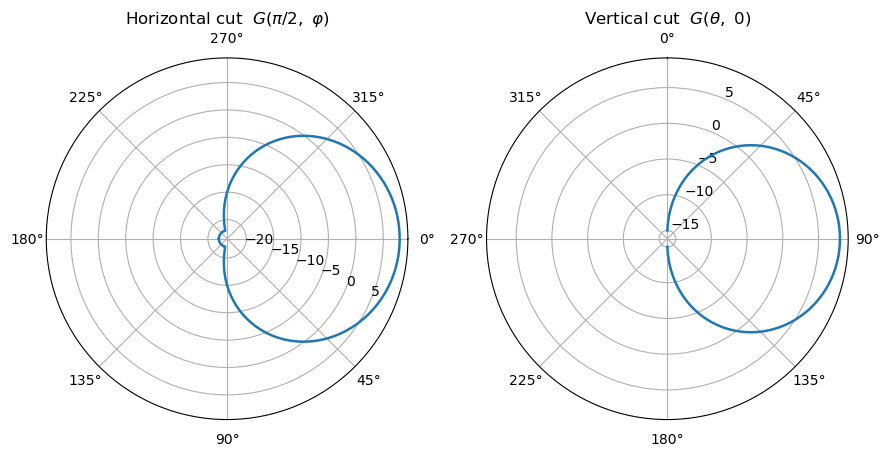

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi
from sionna.rt import PlanarArray

# ------------------------------------------------------------
# 1) Create the antenna element (3GPP TR 38.901, vertical polarization)
# ------------------------------------------------------------
array = PlanarArray(num_rows=8, num_cols=1, pattern="tr38901", polarization="VH")

# ------------------------------------------------------------
# 2) Horizontal cut: theta = 90°, sweep azimuth φ ∈ [-180°, 180°]
# ------------------------------------------------------------
n_az = 361
phi = dr.linspace(mi.Float, -dr.pi, dr.pi, n_az)
theta = dr.full(mi.Float, 0.5 * dr.pi, n_az)
pattern = array.antenna_pattern[0]
C_theta, C_phi = pattern(theta, phi)

gain_linear_h = dr.square(dr.abs(C_theta)) + dr.square(dr.abs(C_phi))
gain_dB_h = 10.0 * dr.log(dr.maximum(gain_linear_h, 1e-15)) / dr.log(10.0)

azimuth_deg = np.linspace(-180.0, 180.0, n_az)
gain_linear_h = np.array(gain_linear_h)
gain_dB_h = np.array(gain_dB_h)
normalized_gain_dB_h = gain_dB_h - np.max(gain_dB_h)

df_h = pd.DataFrame({
    "azimuth_deg": azimuth_deg,
    "gain_dB": gain_dB_h,
    "gain_linear": gain_linear_h,
    "normalized_gain_dB": normalized_gain_dB_h
})

# ------------------------------------------------------------
# 3) Vertical cut: φ = 0°, sweep elevation θ ∈ [0°, 180°]
# ------------------------------------------------------------
n_el = 181
theta = dr.linspace(mi.Float, 0, dr.pi, n_el)
phi = dr.full(mi.Float, 0.0, n_el)
C_theta, C_phi = pattern(theta, phi)

gain_linear_v = dr.square(dr.abs(C_theta)) + dr.square(dr.abs(C_phi))
gain_dB_v = 10.0 * dr.log(dr.maximum(gain_linear_v, 1e-15)) / dr.log(10.0)

elevation_deg = np.linspace(0.0, 180.0, n_el)
gain_linear_v = np.array(gain_linear_v)
gain_dB_v = np.array(gain_dB_v)
normalized_gain_dB_v = gain_dB_v - np.max(gain_dB_v)

df_v = pd.DataFrame({
    "elevation_deg": elevation_deg,
    "gain_dB": gain_dB_v,
    "gain_linear": gain_linear_v,
    "normalized_gain_dB": normalized_gain_dB_v
})

# ------------------------------------------------------------
# 4) Save data to CSV files
# ------------------------------------------------------------

# Save horizontal cut data
df_h.to_csv("antenna_pattern_horizontal_cut.csv", index=False)

# Save vertical cut data
df_v.to_csv("antenna_pattern_vertical_cut.csv", index=False)

print("✅ CSV files saved:")
print(" - antenna_pattern_horizontal_cut.csv")
print(" - antenna_pattern_vertical_cut.csv")


# ------------------------------------------------------------
# 5) Plot both polar cuts
# ------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5), subplot_kw={'projection': 'polar'})

# Horizontal
axs[0].plot(np.deg2rad(df_h["azimuth_deg"]), df_h["gain_dB"], linewidth=1.8)
axs[0].set_theta_zero_location("E")
axs[0].set_theta_direction(-1)
axs[0].set_title(r"Horizontal cut  $G(\pi/2,\ \varphi)$")

# Vertical
axs[1].plot(np.deg2rad(df_v["elevation_deg"]), df_v["gain_dB"], linewidth=1.8)
axs[1].set_theta_zero_location("N")
axs[1].set_theta_direction(-1)
axs[1].set_title(r"Vertical cut  $G(\theta,\ 0)$")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def wrap180(x):
    return ((x + 180.0) % 360.0) - 180.0

def _interp_cross_on_circle(a0, y0, a1, y1, target=-3.0):
    """
    Linear interpolate crossing angle between (a0,y0)->(a1,y1) on a circular axis (deg).
    Returns crossing angle in degrees wrapped to [-180,180].
    """
    # unwrap a1 near a0
    d = a1 - a0
    if d <= -180.0: d += 360.0
    elif d > 180.0: d -= 360.0
    a1_lin = a0 + d
    # interpolate at target
    if y0 == y1:
        a_cross = 0.5*(a0 + a1_lin)
    else:
        t = (target - y0) / (y1 - y0)
        a_cross = a0 + t*(a1_lin - a0)
    return wrap180(a_cross)

def hpbw_azimuth(df_h, gain_col="gain_dB", target=-3.0):
    """
    HPBW for horizontal (azimuth) cut on a circular axis using all segments (incl. wrap).
    df_h must have columns: 'azimuth_deg' and the gain column.
    Returns: (HPBW_deg, left_cross_deg, right_cross_deg, peak_angle_deg)
    """
    ang = df_h["azimuth_deg"].to_numpy(dtype=float)
    g   = df_h[gain_col].to_numpy(dtype=float)

    # Peak & normalize to 0 dB
    p = int(np.argmax(g))
    peak_ang = ang[p]
    g_norm = g - g[p]

    # Collect all -3 dB crossings (including last->first wrap)
    N = len(ang)
    left_rel = None
    right_rel = None

    for i in range(N):
        j = (i + 1) % N
        y0, y1 = g_norm[i], g_norm[j]
        # straddle target? (allow equality)
        if (y0 - target) * (y1 - target) <= 0 and (y0 != y1):
            a_cross = _interp_cross_on_circle(ang[i], y0, ang[j], y1, target)
            # relative to peak in [-180,180]
            rel = wrap180(a_cross - peak_ang)
            # nearest negative rel -> left; nearest positive rel -> right
            if rel < 0:
                if (left_rel is None) or (rel > left_rel):
                    left_rel = rel
            elif rel > 0:
                if (right_rel is None) or (rel < right_rel):
                    right_rel = rel

    if left_rel is None or right_rel is None:
        return (np.nan, np.nan, np.nan, float(peak_ang))

    hpbw = right_rel - left_rel
    left_abs  = wrap180(peak_ang + left_rel)
    right_abs = wrap180(peak_ang + right_rel)
    return (float(hpbw), float(left_abs), float(right_abs), float(peak_ang))

def _interp_cross_linear(x0, y0, x1, y1, target=-3.0):
    if y0 == y1:
        return 0.5*(x0+x1)
    t = (target - y0) / (y1 - y0)
    return x0 + t*(x1 - x0)

def hpbw_elevation(df_v, gain_col="gain_dB", target=-3.0):
    """
    HPBW for vertical (elevation) cut on a linear axis.
    df_v must have columns: 'elevation_deg' and the gain column.
    Returns: (HPBW_deg, left_cross_deg, right_cross_deg, peak_angle_deg)
    """
    ang = df_v["elevation_deg"].to_numpy(dtype=float)
    g   = df_v[gain_col].to_numpy(dtype=float)

    p = int(np.argmax(g))
    peak_ang = ang[p]
    g_norm = g - g[p]

    # Find nearest crossings on each side
    left_cross = None
    right_cross = None

    # Right side
    for i in range(p, len(ang)-1):
        y0, y1 = g_norm[i], g_norm[i+1]
        if (y0 - target) * (y1 - target) <= 0 and (y0 != y1):
            right_cross = _interp_cross_linear(ang[i], y0, ang[i+1], y1, target)
            break

    # Left side
    for i in range(p, 0, -1):
        y0, y1 = g_norm[i], g_norm[i-1]
        if (y0 - target) * (y1 - target) <= 0 and (y0 != y1):
            left_cross = _interp_cross_linear(ang[i], y0, ang[i-1], y1, target)
            break

    if left_cross is None or right_cross is None:
        return (np.nan, np.nan, np.nan, float(peak_ang))

    return (float(right_cross - left_cross), float(left_cross), float(right_cross), float(peak_ang))

# ---- Run on your DataFrames ----
# Horizontal (use your df_h; if you named it df, replace accordingly)
H_hpbw, H_left, H_right, H_peak = hpbw_azimuth(df_h)
print(f"Horizontal HPBW ≈ {H_hpbw:.2f}°  (crossings at {H_left:.2f}°, {H_right:.2f}°; peak at {H_peak:.2f}°)")

# Vertical (use df_v or df_vert)
try:
    V_hpbw, V_left, V_right, V_peak = hpbw_elevation(df_v)
except NameError:
    V_hpbw, V_left, V_right, V_peak = hpbw_elevation(df_vert)
print(f"Vertical   HPBW ≈ {V_hpbw:.2f}°  (crossings at {V_left:.2f}°, {V_right:.2f}°; peak at {V_peak:.2f}°)")
